In [1]:
import pandas as pd
import numpy as np
import math
from struct import *
import base64
import matplotlib.pyplot as plt

# Parser For Abhi

This is a basic parser for blink data and temperature data, assuming the other
subsystems are not operating.

Rename this read_csv to upload and test new data:

In [129]:
cap_data = pd.read_csv('Abhi_Initial_Verify_Data/Data 2022-03-28 180937.csv',header=None)

**Decode header and sort by type into independent dataframes**

In [130]:
def decodeString(input):
  return base64.b64decode(input)

headerTypes = "HHIIIIIIII"
size_of_header = calcsize(headerTypes)
headerLabels = ["packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3", "res4"]

def decodeHeader(input):
  packetType, packetID, msFromStart, epoch, payloadLength, res0, res1, res2, res3, res4 = unpack(headerTypes,input[:size_of_header])
  return packetType, packetID, msFromStart, epoch, payloadLength, res0, res1, res2, res3, res4

cap_data["decoded"] = cap_data[1].apply(decodeString)

cap_data["decoded_header"]=cap_data["decoded"].apply(decodeHeader)
cap_header_data = cap_data["decoded_header"].apply(pd.Series)
cap_header_data.columns = headerLabels
cap_data = cap_data.join(cap_header_data)

cap_data.head()

**Create blink and thermal specific dfs**

In [133]:
raw_blink_df = cap_data[cap_data["packetType"] == 5].reset_index(drop=True)
raw_thermal_df = cap_data[cap_data["packetType"] == 6].reset_index(drop=True)

l_blink = len(raw_blink_df)
l_thermal = len(raw_thermal_df)

print("  Blink entries:\t" + str(l_blink))
print("Thermal entries:\t" + str(l_thermal))

#drop duplicates:
raw_blink_df.drop_duplicates(inplace=True)
raw_thermal_df.drop_duplicates(inplace=True)

print('compare to above for duplicated packet count!')
print("  Blink duplicates:\t" + str(l_blink-len(raw_blink_df)))
print("Thermal duplicates:\t" + str(l_thermal-len(raw_thermal_df)))

Blink entries:	726
Thermal entries:	61
Accel entries:	0
Gyro entries:	0


**Check if any packets dropped**

In [108]:
def packetID_checker(input_df):
  dropped_packets = 0
  duplicate_packets = 0
  pcktID_idx = 0


  for index, row in input_df.iterrows():
    if index == 0:
      pcktID_idx = row["packetID"]
      continue

    delta = row["packetID"] - pcktID_idx

    if delta > 1:
      dropped_packets += 1
    if delta == 0:
      duplicat_packets += 1
    
    pcktID_idx = row["packetID"]

  return dropped_packets

blink_dropped_packets = packetID_checker(raw_blink_df)
thermal_dropped_packets = packetID_checker(raw_thermal_df)

print("Blink packet dropped rate (%):\t\t " + str(100*blink_dropped_packets/len(raw_blink_df)))
print(" Blink packet count:\t\t\t " + str(len(raw_blink_df)))
print("Thermal packet dropped rate (%):\t " + str(100*thermal_dropped_packets/len(raw_thermal_df)))
print(" Thermal packet count:\t\t\t " + str(len(raw_thermal_df)))

## **Define the structs for each payload type & parse**

**Thermal**

In [136]:
#this block spits out 'thermal_df', which contains all the useful raw data

tempTypes = "HHI"
tempSuffixTypes = "II"
tempPacketType = tempTypes * 5 + tempTypes * 5 + tempSuffixTypes
size_of_tempPacketType = calcsize(tempPacketType)
tempLabels = ["temple_tp","temple_thermistor","secondary_temple_tick_ms","nose_tp","nose_thermistor","secondary_nose_tick_ms","tick_ms","epoch"]
tempSuffixLabels = ["tick_ms","epoch"]
tempSamplePeriod_ms = 100


def flatten(t):
  return [item for sublist in t for item in sublist]

def parseThermal(input_df):
  length_of_payload = input_df["payloadLength"]
  num_of_thermal_samples_in_payload = int(length_of_payload/size_of_tempPacketType)

  # remove the header prefix
  payload = input_df["decoded"]
  payload = payload[size_of_header:]

  corePacketLength = 6

  new_df = pd.DataFrame(columns=tempLabels)
  indicies = np.array([0,1,2,3,4,5,6,7])

  for i in range(num_of_thermal_samples_in_payload):
    thermal_samples = np.array(unpack(tempPacketType, payload[i*size_of_tempPacketType:i*size_of_tempPacketType+size_of_tempPacketType]))
    thermal_samples_temp = []
    for j in range(5):
      thermal_samples_temp.append(thermal_samples[(j*3):(j*3+3)])
      thermal_samples_temp.append(thermal_samples[(15+j*3):(15+j*3+3)])

    thermal_samples_temp.append(thermal_samples[-2:])
    thermal_samples = np.array(flatten(thermal_samples_temp))
    # thermal_samples_temp.flatten()

    for j in range(5):
      df_length = len(new_df)
      new_indicie = indicies + corePacketLength * j
      new_indicie[-2] = -2
      new_indicie[-1] = -1
      new_df.loc[df_length] = thermal_samples[new_indicie]
      new_df.at[df_length,"tick_ms"] = new_df.at[df_length,"tick_ms"] - (4-j) * tempSamplePeriod_ms

  new_df["serverTS"] = input_df[0]

  return(new_df)

thermal_df = pd.DataFrame()
for index, row in raw_thermal_df.iterrows():
  thermal_df = thermal_df.append(parseThermal(row))

temple and nose raw thermopile data


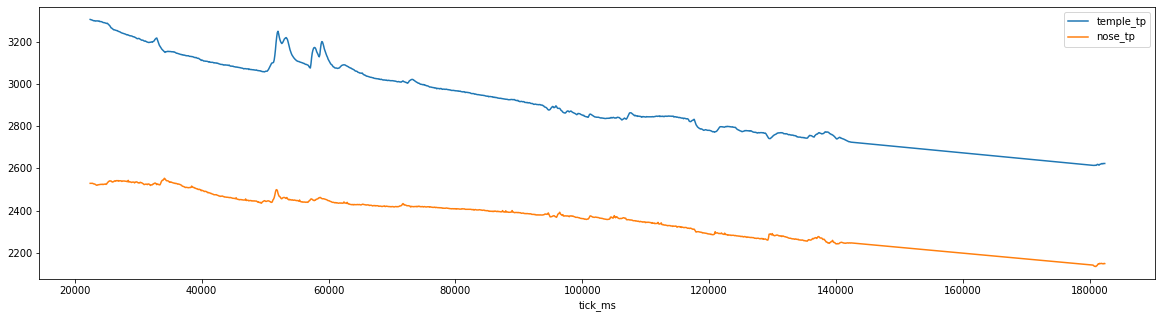

In [170]:
fig, ax = plt.subplots(figsize=(20,5))
thermal_df.plot(x="tick_ms",y="temple_tp", ax=ax)
thermal_df.plot(x="tick_ms",y="nose_tp", ax=ax)
print('temple and nose raw thermopile data')

temple and nose raw thermopile data, zoomed


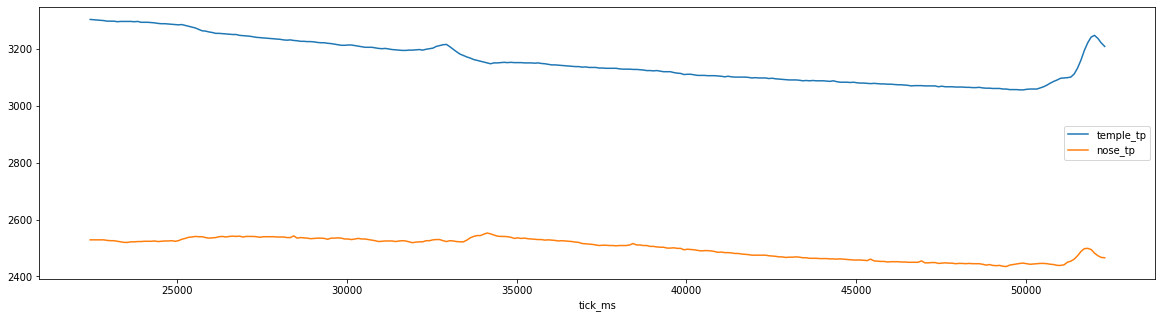

In [171]:
fig, ax = plt.subplots(figsize=(20,5))
thermal_df.iloc[0:300].plot(x="tick_ms",y="temple_tp", ax=ax)
thermal_df.iloc[0:300].plot(x="tick_ms",y="nose_tp", ax=ax)
print('temple and nose raw thermopile data, zoomed')

temple and nose raw *thermistor* data


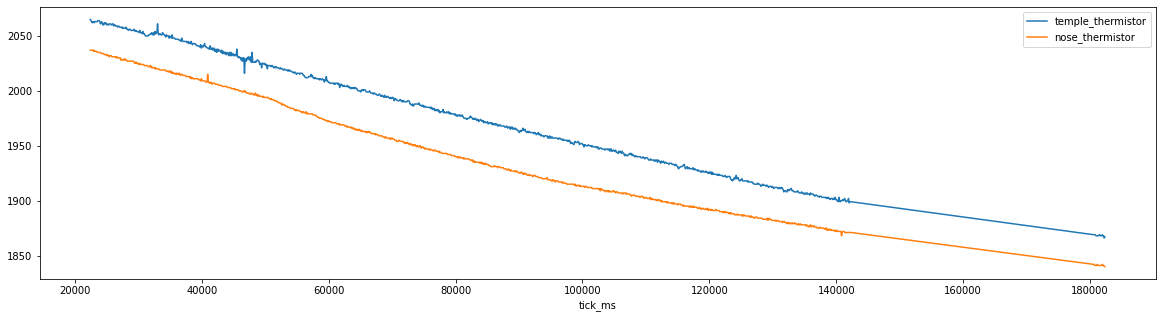

In [172]:
fig, ax = plt.subplots(figsize=(20,5))
thermal_df.plot(x="tick_ms",y="temple_thermistor", ax=ax)
thermal_df.plot(x="tick_ms",y="nose_thermistor", ax=ax)
print('temple and nose raw *thermistor* data')

**Thermal Data Analysis Pipeline**

In [152]:
#this block uses the thermistor and a measured calibration process to convert
#the raw ADC values above to temperature values in C

def convert_thermistor_to_K(raw_value):
    # STEP 1. Calc R_thermistor value given ADC_val
    R_divider = 100000
    ADC_max = 4095
    
    R_t = (R_divider * raw_value/ADC_max) / (1 - raw_value/ADC_max)
    
    # STEP 2. Convert R_t to temp
    R_0 = 100000
    T_0 = 298.15
    Beta = 3960
    R_inf = R_0 * math.exp(-Beta/T_0)
    
    Temp_K = Beta / np.log(R_t / R_inf)
    return Temp_K
    
def convert_thermopile_to_C(raw_val, T_ref_K, A, a_0, a_1):
    #STEP 1. Calc V_thermopile based on preamp gain and bias
    V_tp = (((raw_val / 4095) * 3.3) - (1.15+0.6084))/1000.0
    
    #STEP 2. Solve for Temperature!
    f_V_tp = (V_tp - a_0) + a_1 * (V_tp - a_0)**2
    T_obj = (T_ref_K**4 + f_V_tp/A)**0.25
    return (T_obj - 273.15)
    
def convert_nose_temp(raw_val, raw_thermistor):
    A   =  7.8e-10
    a_0 = -2.31e-01
    a_1 =  3.61e-03
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)
    
def convert_temple_temp(raw_val, raw_thermistor):
    A   =  4.21e-10
    a_0 = -3.62e-01
    a_1 =  8.31e-02
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)

thermal_df['nose_temp_C'] = thermal_df.apply(lambda x: convert_nose_temp(x['nose_tp'], x['nose_thermistor']), axis=1)
thermal_df['temple_temp_C'] = thermal_df.apply(lambda x: convert_temple_temp(x['temple_tp'], x['temple_thermistor']), axis=1)

compensated nose and temple temperatures in Celcius


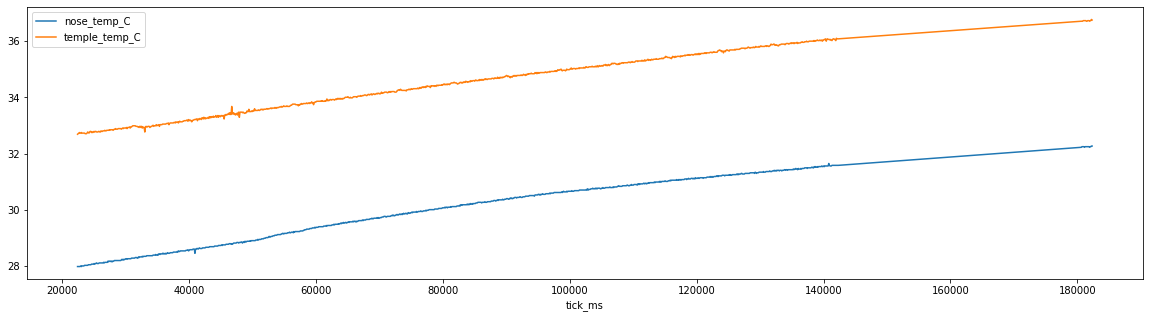

compensated nose and temple temperatures in Celcius, Zoomed


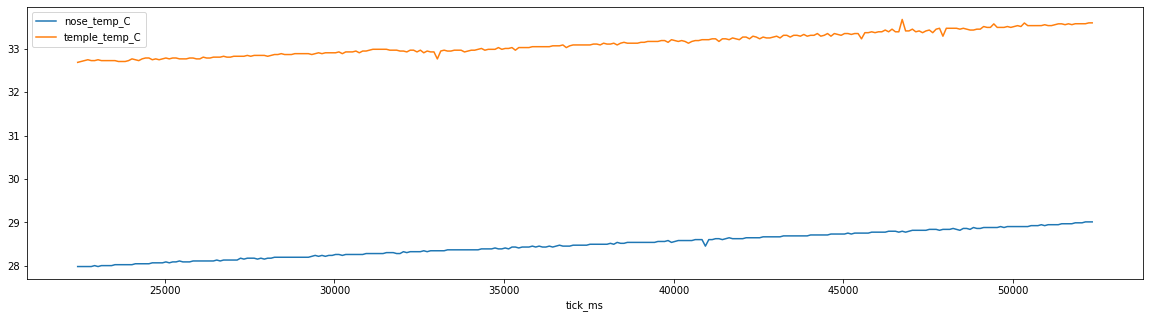

In [174]:
print('compensated nose and temple temperatures in Celcius')
fig, ax = plt.subplots(figsize=(20,5))  
thermal_df.plot(x="tick_ms",y="nose_temp_C", ax=ax)
thermal_df.plot(x="tick_ms",y="temple_temp_C", ax=ax)
plt.show()

print('compensated nose and temple temperatures in Celcius, Zoomed')
fig, ax = plt.subplots(figsize=(20,5))  
thermal_df.iloc[0:300].plot(x="tick_ms",y="nose_temp_C", ax=ax)
thermal_df.iloc[0:300].plot(x="tick_ms",y="temple_temp_C", ax=ax)
plt.show()

differential (nose-temple) in Celcius, with 5x time average overlay


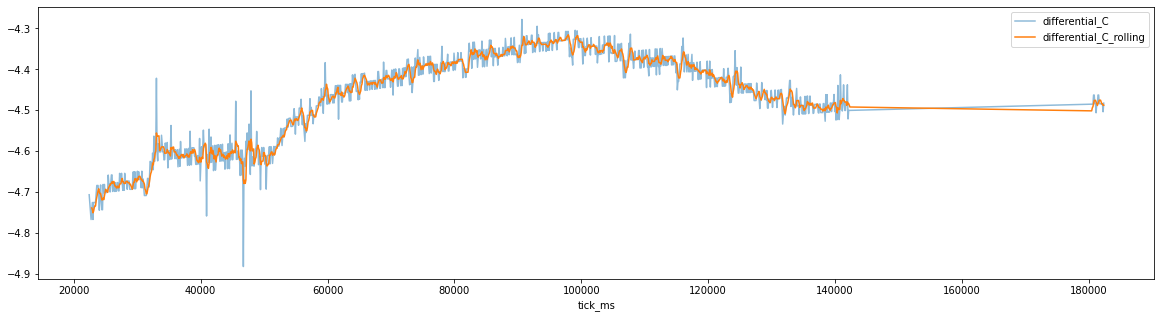

In [175]:
thermal_df['differential_C'] = thermal_df['nose_temp_C'] - thermal_df['temple_temp_C']
thermal_df['differential_C_rolling'] = thermal_df['differential_C'].rolling(5).mean()

fig, ax = plt.subplots(figsize=(20,5)) 
thermal_df.plot(x="tick_ms",y="differential_C", ax=ax, alpha=0.5)
thermal_df.plot(x="tick_ms",y="differential_C_rolling", ax=ax)
print('differential (nose-temple) in Celcius, with 5x time average overlay')

# Blink Processing

**Blink**

In [169]:
blinkTypes = "B"
size_of_blink = calcsize(blinkTypes)
blinkLabels = ["data"]
blinkSampleRate = 1000 # 1kHz
blinkSamplePeriod_ms = 1000 * (1/blinkSampleRate) # 1 ms

def parseBlink(input_df):
  length_of_payload = input_df["payloadLength"]
  num_of_blink_samples_in_payload = int(length_of_payload/size_of_blink)

  # remove the header prefix
  payload = input_df["decoded"]
  payload = payload[size_of_header:]

  blink_samples = unpack(str(num_of_blink_samples_in_payload)+blinkTypes, payload)
  new_df = pd.DataFrame(blink_samples, columns=["data"])
  new_df["packetID"] = input_df["packetID"]
  new_df["epoch"] = input_df["epoch"] # not used
  new_df["serverTS"] = input_df[0]
  timeStamps = np.arange(input_df["msFromStart"] - num_of_blink_samples_in_payload * blinkSamplePeriod_ms + 1, input_df["msFromStart"] + 1, blinkSamplePeriod_ms)
  new_df["msFromStart"] = timeStamps.astype(int)
  new_df["saturated"] = input_df["res0"] # if 1, the emitter is off because there is too much NIR light in the room which causes sensor to saturate

  return new_df

blink_df = pd.DataFrame()
for index, row in raw_blink_df.iterrows():
  blink_df = blink_df.append(parseBlink(row))

raw blink data


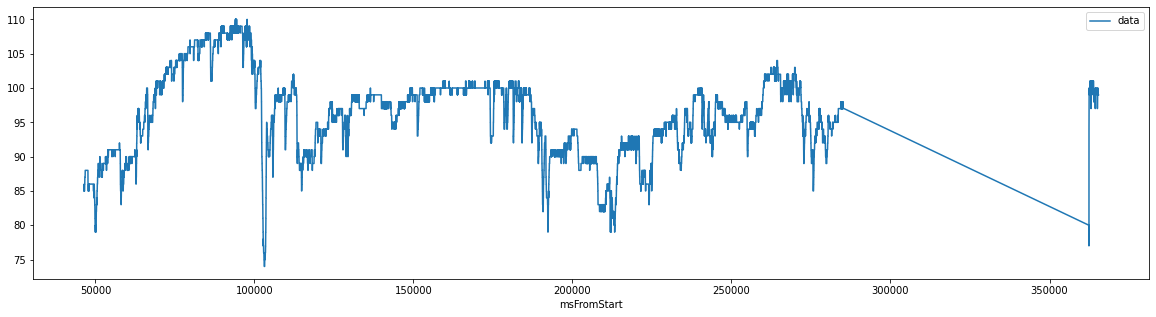

In [178]:
fig, ax = plt.subplots(figsize=(20,5)) 
blink_df.plot(x='msFromStart', y="data", ax=ax)
print('raw blink data')

**Blink data processing pipeline**

In [194]:
def grab_blinks(blink_sess, thresh=0.06, blink_dur_ms=175, lpf_samples=50, dx_lpf_samples=25, reverse=False, plot=True, xlims=None):
    #get array of (1)timestamps of blinks, (2) [peak close velocity, peak open velocity], (3) duration
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    blink_sess = blink_sess.sort_values(by=['msFromStart'], ascending=True)

    #step 1: LPF input, take derivative, LPF derivative
    smooth_input = moving_average(blink_sess['data'], lpf_samples)
    dx = np.append([np.nan], np.diff(smooth_input))
    smooth_dx = moving_average(dx, dx_lpf_samples)
    df_results = pd.DataFrame({'timestamp_ms':blink_sess['msFromStart'], 'dx':smooth_dx})
        
    #step 2, apply threshold
    if reverse:
        decision = (smooth_dx > thresh)
    else:
        decision = (smooth_dx < -1*thresh)

    #step 3, use this thresholded value to decide if we are blinking subject to debounce.
    #grab the blink time. within the bounds of the blink, find the duration and peak velocities using the derivative.
    df_blinks = pd.DataFrame()
    samples_per_blink = int(blink_dur_ms)  # happen to sample at 1kHz so 1 sample == 1 ms
    samples_blink_debounce = int(samples_per_blink/4)
    i, blinkrow = 0, {}
    while i<len(decision):
        if decision[i]: #we have a blink
            blinkrow['timestamp_ms'] = df_results['timestamp_ms'].iloc[i] #timestamp of this blink
            
            df_thisblink = df_results.iloc[i:i+samples_per_blink] #grab the data associated with this blink
            df_thisblink.reset_index(inplace=True)
            
            if reverse:
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].iloc[0:max_open.index[-1]].max()]
            else:
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].iloc[0:max_open.index[-1]].min()]
            try:
                blinkrow['close_time'] = max_close['timestamp_ms'].iloc[0]
                blinkrow['open_time'] = max_open['timestamp_ms'].iloc[-1]
                blinkrow['vel_close'] = abs(max_close['dx'].iloc[0]) #peak close velocity
                blinkrow['vel_open']  = abs(max_open['dx'].iloc[-1]) #peak open velocity
                blinkrow['duration_ms'] = max_open['timestamp_ms'].iloc[-1] - max_close['timestamp_ms'].iloc[0] #duration
 
                df_blinks = df_blinks.append(blinkrow, ignore_index=True)
            
            except:
                print('failed to add blink from data at timestamp ', blinkrow['timestamp_ms'])

            
            i += max(max_open.index[-1], samples_blink_debounce)  #move ahead to end of blink, or blink_dur/4, whichever is longer
            
        else: i += 1
            
    if plot:
        fig, ax = plt.subplots(2,1, figsize=(20,10)) 
        blink_sess.plot(x="msFromStart",y="data",ax=ax[0])
        avgval = blink_sess.data.mean()
        for i,r in df_blinks.iterrows():
            ax[0].plot([r['timestamp_ms'], r['timestamp_ms']],[0, 1000], color='purple', alpha=0.5)
            ax[1].plot([r['timestamp_ms'], r['timestamp_ms']],[-5, 5], color='purple', alpha=0.5)
            ax[1].plot([r['close_time'], r['close_time']],[-5, 5], color='green', alpha=0.2)
            ax[1].plot([r['open_time'], r['open_time']],[-5, 5], color='red', alpha=0.2)
            
        df_results.plot(x="timestamp_ms",y="dx",ax=ax[1], color='orange')
        
        ax[0].set_ylim(blink_sess['data'].iloc[500:-500].min(), blink_sess['data'].iloc[500:-500].max())   
        ax[1].set_ylim(df_results['dx'].iloc[500:-500].min(), df_results['dx'].iloc[500:-500].max())   
        
        ax[0].set_title('raw blink detect signal with blinks superimposed')
        ax[1].set_title('dx/dt of raw blink signal with blinks superimposed, including open/close of eyes')
        
        if xlims is not None:
            ax[0].set_xlim(xlims)
            ax[1].set_xlim(xlims)
            
    return df_blinks


failed to add blink from data at timestamp  365359
    close_time  duration_ms  open_time  timestamp_ms  vel_close  vel_open
0      66479.0        125.0    66604.0       66447.0     0.0816    0.0200
1      77354.0        156.0    77510.0       77337.0     0.0808    0.0248
2      86207.0        161.0    86368.0       86194.0     0.0656    0.0000
3     102272.0        112.0   102384.0      102233.0     0.0800    0.0240
4     105750.0        119.0   105869.0      105708.0     0.1008    0.0328
5     109620.0        143.0   109763.0      109589.0     0.0848    0.0000
6     113382.0        136.0   113518.0      113352.0     0.0880    0.0264
7     120907.0        162.0   121069.0      120895.0     0.0688    0.0200
8     127724.0        157.0   127881.0      127707.0     0.0680    0.0200
9     128746.0        162.0   128908.0      128734.0     0.0712    0.0296
10    129325.0        115.0   129440.0      129321.0     0.0608    0.0296
11    151194.0        147.0   151341.0      151167.0     0.08

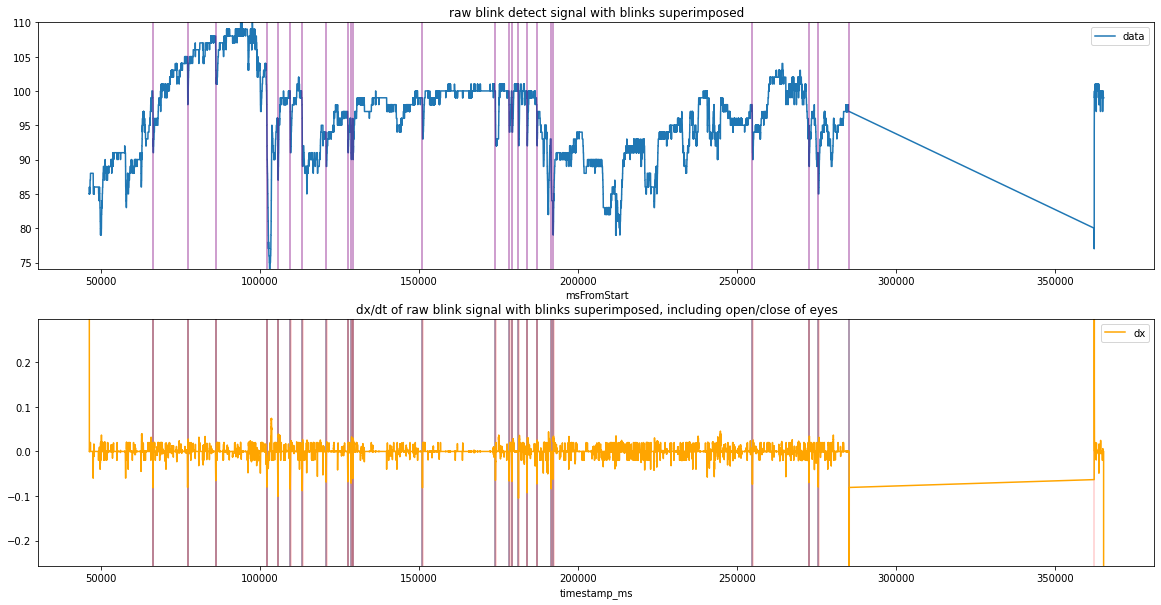

In [195]:
# grab_blinks will take the raw data and a threshold, and look at a LPF version of
# the first derivative signal to isolate blinks (with some debounce).  

# play with the threshold to get better results or use the automated script in the
# sections below to autogenerate a threshold.  Here we'll just use a 'default'
# threshold and see what we get.

# Can zoom on plot by passing xlims argument

# Beware that some users have weird reflections/bad alignment with the white of
# eye and instead of a dip in light you might see a spike when blinking.  
# These users require the 'reverse' flag.

blink_data = grab_blinks(blink_df)
print(blink_data)

In [199]:
# the above can be tuned with threshold and blink_duration (max duration to search)
# for an 'auto-threshold' based on user data, we can do the below:

# for this function, we assume a number of blinks per minute, and auto pick the
# threshold assuming a certain number of true blinks.  In real trials,
# blinks per minute varied between 10 and 60 on our test subjects, most are are 
# 15.  If your data includes periods without the glasses on, that should be 
# taken into account

def auto_determine_threshold(blink_df, est_blink_per_min=60, reverse=False, average_num=5, lower_bound_thresh_step=0.001):
    #pass in a raw blink_df that has at least average_num blinks in it.  It will run and identify 
    
    #In our initial test, we had between 10 and 60 blinks per minute
    #therefore we want to grab ~secs+5 'blinks'
    target_blinks = int((blink_df.iloc[-1]['msFromStart'] - blink_df.iloc[0]['msFromStart']) / (1000)*(est_blink_per_min/60) + 5)
    print('want to grab ', target_blinks)
    
    #GRAB BLINKs at 0.05
    best_thresh = 0.05
    current_thresh = 0.05
    best_distance = 1000
    current_distance = 1001
    
    for i in range(1000):
        df_glasses_blinks = grab_blinks(blink_df, thresh=current_thresh, blink_dur_ms=175, reverse=reverse, plot=False)
        print('...got ', len(df_glasses_blinks), ' blinks at ', current_thresh)
        current_distance = abs(target_blinks - len(df_glasses_blinks))
        
        if current_distance <= best_distance:
            best_distance = current_distance
            best_thresh = current_thresh
            if target_blinks > len(df_glasses_blinks):
                current_thresh -= lower_bound_thresh_step
            else:
                current_thresh += lower_bound_thresh_step
        else: 
            if current_distance == 0: #hit it perfectly
                best_thresh = current_thresh
            break
    
    #finished
    print('DONE after ', i, ' iterations. Using threshold ', current_thresh)
    
    df_glasses_blinks = grab_blinks(blink_df, thresh=best_thresh, blink_dur_ms=175, reverse=reverse, plot=False)
    print('...got ', len(df_glasses_blinks), ' blinks at ', current_thresh)
        
    #get first N vel_closed, sorted
    first_velocities = sorted(df_glasses_blinks['vel_close'].iloc[:target_blinks].tolist())
    #assume the AVG_NUM most powerful are blinks, and the 5 least are not
    not_blink = sum(first_velocities[:average_num])/average_num
    blink = sum(first_velocities[-average_num:])/average_num
    #set threshold accordingly
    thresh = not_blink + (blink-not_blink)/4
    print('THRESHOLD: ', thresh)
    return thresh

thresh = auto_determine_threshold(blink_df, est_blink_per_min=15)

want to grab  84
failed to add blink from data at timestamp  365359
...got  32  blinks at  0.05
failed to add blink from data at timestamp  365359
...got  32  blinks at  0.049
failed to add blink from data at timestamp  365359
...got  37  blinks at  0.048
failed to add blink from data at timestamp  365359
...got  38  blinks at  0.047
failed to add blink from data at timestamp  365359
...got  38  blinks at  0.046
failed to add blink from data at timestamp  365359
...got  38  blinks at  0.045
failed to add blink from data at timestamp  365359
...got  39  blinks at  0.044
failed to add blink from data at timestamp  365359
...got  39  blinks at  0.043
failed to add blink from data at timestamp  365359
...got  40  blinks at  0.041999999999999996
failed to add blink from data at timestamp  365359
...got  42  blinks at  0.040999999999999995
failed to add blink from data at timestamp  365359
...got  54  blinks at  0.039999999999999994
failed to add blink from data at timestamp  365359
...got  

failed to add blink from data at timestamp  365359
    close_time  duration_ms  open_time  timestamp_ms  vel_close  vel_open
0      47667.0        162.0    47829.0       47655.0     0.0600    0.0016
1      57867.0         67.0    57934.0       57830.0     0.0600    0.0016
2      66479.0        125.0    66604.0       66441.0     0.0816    0.0200
3      77354.0        150.0    77504.0       77330.0     0.0808    0.0248
4      86207.0        150.0    86357.0       86183.0     0.0656    0.0000
5     102272.0        112.0   102384.0      102214.0     0.0800    0.0240
6     105750.0        119.0   105869.0      105695.0     0.1008    0.0328
7     109620.0        132.0   109752.0      109578.0     0.0848    0.0000
8     113382.0        132.0   113514.0      113342.0     0.0880    0.0264
9     118154.0        104.0   118258.0      118146.0     0.0560    0.0200
10    119896.0         54.0   119950.0      119890.0     0.0528    0.0128
11    120907.0        150.0   121057.0      120883.0     0.06

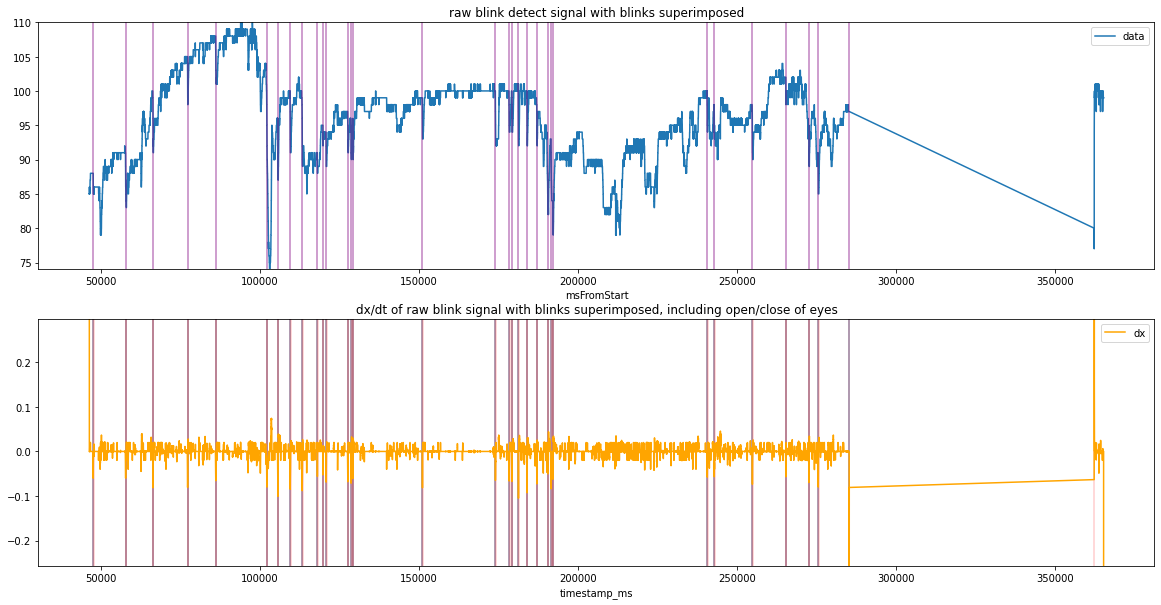

In [200]:
#now we can re-plot the results with the new threshold

r = grab_blinks(blink_df, thresh=thresh)
print(r)

In [ ]:
#if this doesn't look good, play with blink_duration, threshold, LPF values.